IA307 TP 2 - ZARKA-ARTHUS Simon

Linear classification

We implement a stochastic gradient descent (SGD) with basic implementation first then with mini-batches. Then we compare diffents hyperparameters and show the best results we have.

To do it we complete the file classifier_math evaluate accuracy and linear classification.

# Installation

In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


Download repository with helper_cuda.h:

In [ ]:
!git clone https://github.com/NVIDIA/cuda-samples.git

Cloning into 'cuda-samples'...
remote: Enumerating objects: 25913, done.
remote: Counting objects: 100% (13300/13300), done.
remote: Compressing objects: 100% (1403/1403), done.
remote: Total 25913 (delta 12629), reused 11897 (delta 11897), pack-reused 12613 (from 2)
Receiving objects: 100% (25913/25913), 134.14 MiB | 12.70 MiB/s, done.
Resolving deltas: 100% (23003/23003), done.
Updating files: 100% (2498/2498), done.


Based on the lecture at https://sites.google.com/site/frehseg/teaching/ia307

# Provided Code




## CUDA Utilities

In [ ]:
%%writefile cuda_stuff.cuh
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>

#ifndef cuda_stuff_H
#define cuda_stuff_H

/* transform matrix index to vector offset
   Since CUDA uses column major,
   nb_rows = number of rows */
#define IDX2C(i,j,nb_rows) (((j)*(nb_rows))+(i))

//MACRO TO DEBUGG CUDA FUNCTIONS
/** Error checking,
 *  taken from https://stackoverflow.com/questions/14038589/what-is-the-canonical-way-to-check-for-errors-using-the-cuda-runtime-api
 */
#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}
/** Error checking for use with CUDA Dynamic Parallelism */
/*
#define cdpErrchk(ans) { cdpAssert((ans), __FILE__, __LINE__); }
__device__ void cdpAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      printf("GPU kernel assert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) assert(0);
   }
}
*/
void device_synchronize();

#endif


Writing cuda_stuff.cuh


In [ ]:
%%writefile cuda_stuff.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include "cuda_stuff.cuh"

void device_synchronize(){
    gpuErrchk(cudaDeviceSynchronize());
}

Writing cuda_stuff.cu


## fmatrix Matrix Tools

In [ ]:
%%writefile fmatrix.cuh
#ifndef fmatrices_H
#define fmatrices_H
#include "cuda_stuff.cuh" // for IDX2C

////////////////////////////////////////
// basic data structure and access macro
////////////////////////////////////////
typedef struct {
    float* data;
    int cols;
    int rows;
} fmatrix;

/** Access element (i,j) of matrix M
 *
 *  Usage example:
 *  For computing A = B^T + C), loop over i and j with:
 *    getfm(A,i,j) = getfm(B,j,i) + getfm(C,i,j);
 **/
#define getfm(M,i,j) (M.data[IDX2C(i,j,M.rows)])

////////////////////////////////////////
// utility functions
////////////////////////////////////////
/** Returns the number of elements in the matrix.
 *
 *  Useful for computing, e.g., the size
 *  of a 1D-vector that contains the same numbers.
 */
 __host__
 __device__
int fmatrix_elements(fmatrix mat);

/** Returns the memory occupied by the matrix elements in bytes
 *  (not including the variables in the struct mat).
 *
 *  Useful for allocating memory for the data.
 */
 __host__
 __device__
int fmatrix_size(fmatrix mat);

/** Assert that the matrix is coherent: all fields nonzero. */
 __host__
 __device__
void fmatrix_assert(fmatrix mat);

////////////////////////////////////////
// Create, copy, destroy
////////////////////////////////////////
/** Allocate memory on host */
fmatrix fmatrix_create_on_host(int rows, int cols);

/** Allocate memory on device */
fmatrix fmatrix_create_on_device(int rows, int cols);

/** Create a matrix representing columns [a,b) of M.
 *  Note that the new matrix uses a pointer to the
 *  data of M. The data is not copied to a new location.
 *  If M is destroyed, this matrix is useless.
 */
fmatrix fmatrix_subcolumns(fmatrix M, int a, int b);

/** Copy data from matrix on device to host
 *  (no memory allocation). */
void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device);

/** Copy data from matrix on host to device
 *  (no memory allocation). */
void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device);

/** Copy matrix from device to host, allocating new memory. */
fmatrix fmatrix_copy_to_host(fmatrix mat_device);

/** Copy matrix from host to device, allocating new memory. */
fmatrix fmatrix_copy_to_device(fmatrix mat_host);

/** Free data memory on host.
 *  This zeros out the data pointer of the fmatrix struct,
 *  so a pointer is required. */
void fmatrix_free_on_host(fmatrix* mat);

/** Free data memory on device.
 *  This zeros out the data pointer of the fmatrix struct,
 *  so a pointer is required. */
void fmatrix_free_on_device(fmatrix* mat);

////////////////////////////////////////
// Input and Output
////////////////////////////////////////

/** Print the first nb rows of the matrix mat
 *  on the host.
 *  If nb<0, print all rows.
 */
 __host__
 __device__
void fmatrix_print(fmatrix mat, int nb=-1);

/** Print the first nb rows of the matrix mat
 *  on the device.
 *  If nb<0, print all rows.
 *
 *  This version copies the matrix to host first.
 */
void fmatrix_device_print(fmatrix mat, int nb=-1);

/** Print a matrix to a csv file.
 *
 *  This version copies the matrix to host first.
 */
void fmatrix_device_to_csv(const char* filename, fmatrix mat);

/** Read a matrix from a csv file.
 *
 *  This version creates the matrix on the host first.
 */
fmatrix fmatrix_device_from_csv(const char* filename);

////////////////////////////////////////
// Useful
////////////////////////////////////////

/** Create a matrix with random values between -1 and 1
 *  on the device */
fmatrix fmatrix_create_random_on_device(int rows, int cols);

#endif


Writing fmatrix.cuh


In [ ]:
%%writefile fmatrix.cu
#include <assert.h>
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include <curand.h>
#include <curand_kernel.h>
#include "cuda_stuff.cuh"
#include "fmatrix.cuh"

// for reading CSV files, we use some C++
#include <iostream>
#include <iomanip>
#include <fstream>
#include <string>

int fmatrix_elements(fmatrix mat) {
     return mat.cols*mat.rows;
}

int fmatrix_size(fmatrix mat) {
//    fmatrix_assert(mat);
     return fmatrix_elements(mat) * sizeof(float);
}

void fmatrix_assert(fmatrix mat) {
    assert(mat.data);
    assert(mat.cols);
    assert(mat.rows);
}

fmatrix fmatrix_create_on_host(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    mat.data = (float*)malloc(fmatrix_size(mat));
    assert(mat.data);
    return mat;
}

fmatrix fmatrix_create_on_device(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    gpuErrchk(
        cudaMalloc((void **)&(mat.data), fmatrix_size(mat))
    );
    return mat;
}

void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk(
        cudaMemcpy( mat_device.data, mat_host.data,
                   fmatrix_size(mat_host),
                   cudaMemcpyHostToDevice
                   )
        );
}

void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk(
        cudaMemcpy( mat_host.data, mat_device.data,
                   fmatrix_size(mat_device),
                   cudaMemcpyDeviceToHost
                   )
        );
}

fmatrix fmatrix_copy_to_host(fmatrix mat_device) {
    fmatrix_assert(mat_device);
    fmatrix mat_host = fmatrix_create_on_host(mat_device.rows, mat_device.cols);
    fmatrix_data_to_host(mat_host,mat_device);
    return mat_host;
}

fmatrix fmatrix_copy_to_device(fmatrix mat_host) {
    fmatrix_assert(mat_host);
    fmatrix mat_device = fmatrix_create_on_device(mat_host.rows, mat_host.cols);
    fmatrix_data_to_device(mat_host,mat_device);
    return mat_device;
}

/** We could do it like this, but it would not set our pointer M.data to 0.
... fmatrix_free_on_host(M)
void fmatrix_free_on_host(fmatrix mat) {
    fmatrix_assert(mat);
  free(mat.data);
  mat.data = 0;
  mat.cols = 0;
  mat.rows = 0;
}
*/

void fmatrix_free_on_host(fmatrix* mat) {
    fmatrix_assert(*mat);
  free(mat->data);
  mat->data = 0;
  mat->cols = 0;
  mat->rows = 0;
}

void fmatrix_free_on_device(fmatrix* mat) {
    fmatrix_assert(*mat);
  gpuErrchk(cudaFree(mat->data));
  mat->data = 0;
  mat->cols = 0;
  mat->rows = 0;
}

fmatrix fmatrix_subcolumns(fmatrix M, int a, int b) {
    fmatrix_assert(M);
    fmatrix A = {
        .data = &getfm(M,0,a),
        .cols = b-a,
        .rows = M.rows
    };
    fmatrix_assert(A);
    return A;
}


__host__
__device__
void fmatrix_print(fmatrix mat, int nb){
    if (nb<0 || nb > mat.rows) {
        nb = mat.rows;
    }
    printf("[\n");
    for (int i = 0 ; i < nb; i++){
      for (int j = 0 ; j<mat.cols; j++){
        printf("%f", getfm(mat,i,j));
        if (j+1<mat.cols) {
          printf(",\t");
        }
      }
      if (i+1<nb) {
        printf(";\n");
      }
    }
    if (nb < mat.rows) {
      printf("\n...\n");
    }
  printf("\n]\n");
}

void fmatrix_device_print(fmatrix mat, int nb){
   // allocate copy
   fmatrix tmp = fmatrix_copy_to_host(mat);
   fmatrix_print(tmp,nb);
   fmatrix_free_on_host(&tmp);
}

void fmatrix_device_to_csv(const char* filename, fmatrix mat) {
  // Open file
  FILE* fp = fopen(filename, "w");
  // allocate copy
  fmatrix tmp = fmatrix_copy_to_host(mat);
  for (int i = 0 ; i < tmp.rows; i++){
    for (int j = 0 ; j<tmp.cols; j++){
      // Note: %.15g gives 15 significant digits (full double precision)
      fprintf(fp,"%.15g", getfm(tmp,i,j));
      if (j+1<tmp.cols) {
        fprintf(fp,",");
      }
    }
    fprintf(fp,"\n");
  }
  fmatrix_free_on_host(&tmp);
  // Close file
  fclose(fp);
}

__global__
void fmatrix_create_random_on_device_kernel(fmatrix M) {
    // choose a seed (here: the same each launch)
    unsigned long seed = 0;
    int sequence = 0;
    // first, initialize the random numbers
    curandState state;
    curand_init(seed, sequence, 0, &state);
    for (int i = 0; i < fmatrix_elements(M); ++i) {
        // curand_uniform creates numbers between 0 and 1
        M.data[i] = (curand_uniform(&state)-0.5)*2.0;
    }
}

fmatrix fmatrix_create_random_on_device(int rows, int cols) {
    // Create an uninitialized matrix on the device
    fmatrix M = fmatrix_create_on_device(rows,cols);
    // Call a kernel with a single thread to fill the values
    fmatrix_create_random_on_device_kernel<<<1,1>>>(M);

    return M;
}

/* Count the number of rows and columns in a csv files (without headers) */
void count_elements_in_csv(const char* filename, int* rows, int* cols) {
  // Note: for the sake of convenience, we use some C++ functions here
  using namespace std;

  *rows = 0;
  *cols = 0;
  string row_as_string;
  string value;
  ifstream infile;
  infile.open(filename, ifstream::in);
	if (infile.is_open())
  {
    while (getline(infile, row_as_string, '\n')) {
				istringstream line_stream(row_as_string);
        int tempcols = 0;
        while (getline(line_stream, value, ',')) {
          ++tempcols;
        }
        if (tempcols > *cols) {
           *cols = tempcols;
        }
        ++(*rows);
			}
		infile.close();
	}
	else cout << "Cannot open file." << endl;
}

/** Read the data from a csv file into an fmatrix on the host.
 *  Careful: We assume that the matrix has the right dimensions!
 *  Use count_elements_in_csv(...) to get the dimensions if
 *  unknown.
 */
void fmatrix_fill_from_csv(fmatrix h_M,const char* filename) {
  // Note: for the sake of convenience, we use some C++ functions here
  using namespace std;
  string row_as_string;
  string value;
  ifstream infile;
  infile.open(filename, ifstream::in);
  int row = 0;
	if (infile.is_open())
  {
    while (getline(infile, row_as_string, '\n')) {
				istringstream line_stream(row_as_string);
        int col = 0;
        while (getline(line_stream, value, ',')) {
					getfm(h_M,row,col) = strtod(value.c_str(), NULL);
          ++col;
				}
        ++row;
			}
		infile.close();
	}
	else cout << "Cannot open file." << endl;
}

fmatrix fmatrix_device_from_csv(const char* filename) {
  // first read the file to count the number of elements
  int rows = 0;
  int cols = 0;
  count_elements_in_csv(filename,&rows,&cols);

  // allocate the matrix on the host
  fmatrix h_M = fmatrix_create_on_host(rows,cols);

  // read the data into the host matrix
  fmatrix_fill_from_csv(h_M,filename);

  // copy the matrix to the device
  fmatrix M = fmatrix_copy_to_device(h_M);

  // destroy the host matrix
  fmatrix_free_on_host(&h_M);

  return M;
}




Writing fmatrix.cu


## Data I/O

In [ ]:
%%writefile read_csv.cuh
#include <cuda_runtime.h>
#ifndef read_csv_H
#define read_csv_H

void read_csv(const char* filename, float* data_array,int nbrow,int nbcol);

#endif

Writing read_csv.cuh


In [ ]:
%%writefile read_csv.cu


#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

#include "read_csv.cuh"
#include "cuda_stuff.cuh" // for matrix indexing

using namespace std;

/////////////////////////////////////////////////////////
// Functions for reading the dataset from a file
/////////////////////////////////////////////////////////

/* Read a csv file with a given number of rows and columns */
void read_csv(const char* filename, float* data_array,int nbrow,int nbcol) {
  string row_as_string;
  string value;
  double ioTemp;
  ifstream infile;
  infile.open(filename, ifstream::in);
  int row_count = 0;
	if (infile.is_open())
  {
      // read the headers (and discard)
			getline(infile, row_as_string, '\n');
      cout << "headers: " << row_as_string << "!" << std::endl;
      for(int i = 0; i < nbrow; i++){
  			getline(infile, row_as_string, '\n');
        // cout << "read line " << row_as_string << "!" << std::endl;
				istringstream line_stream(row_as_string);
			  for(int j = 0; j < nbcol; j++){
          getline(line_stream, value, ',');
					ioTemp = strtod(value.c_str(), NULL);
          // cout << "("<<i<<","<<j<<") = "<< ioTemp << std::endl;

					data_array[IDX2C(i,j,nbrow)] = ioTemp;

				}
        ++row_count;
			}
		infile.close();
    cout << "Read " << row_count << " rows." << std::endl;
	}
	else cout << "Cannot open file." << endl;
}



Writing read_csv.cu


In [ ]:
%%writefile preprocess_data.cuh

#include <cuda_runtime.h>
#ifndef preprocess_data_H
#define preprocess_data_H

void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels );

#endif

Writing preprocess_data.cuh


In [ ]:
%%writefile preprocess_data.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "preprocess_data.cuh"

using namespace std;

/* transform matrix index to vector offset
   Since CUDA uses column major,
   ld = number of rows
   Example of use: a[IDX2C(0, 1, 50)] */
#define IDX2C(i,j,ld) (((j)*(ld))+(i))

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)
/////////////////////////////////////////////////////////
// Functions for preprocessing the data set
/////////////////////////////////////////////////////////

/* Split data into inputs and labels. Allocated memory for inputs and labels.
   Since cuBLAS is column major, each input is in a column.
   We also add 1.0 as first element to each input vector.
*/
void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels ) {
    // The inputs are the first nbrows-1 columns.
    // The labels are the last column (index nbrows-1), booleanized
    // by the condition >= above_threshold
    *input_array = (float *)malloc(nbrows * nb_inputs * sizeof(float));
    *label_array = (float *)malloc(nbrows * nb_labels * sizeof(float));
    //cout << &input_array << " and "<< &label_array << " data " << data_array << std::endl;
    cout << "Allocated memory for inputs: " << nbrows << " rows, "<< nb_inputs << " columns." << std::endl;
    cout << "Allocated memory for labels: " << nbrows << " rows, "<< nb_labels << " columns." << std::endl;

    // Copy the data to X
    for(int i = 0; i < nbrows; i++){
      // Set the first element of each x to 1
      (*input_array)[IDX2C(0,i,nb_inputs)] = 1.0;
      // Copy the rest of x
			for(int j = 1; j < nb_inputs; j++){
				(*input_array)[IDX2C(j,i,nb_inputs)] = data_array[IDX2C(i,j-1,nbrows)];
			}
      float median_house_value = data_array[IDX2C(i,nbcols-1,nbrows)];
      (*label_array)[IDX2C(0,i,nb_labels)] = 0.0;
      (*label_array)[IDX2C(1,i,nb_labels)] = 0.0;
      if (median_house_value >= above_threshold) {
        (*label_array)[IDX2C(0,i,nb_labels)] = 1.0;
      } else {
        (*label_array)[IDX2C(1,i,nb_labels)] = 1.0;
      }
		}

    // Show some entries for double checking
    cout << "Inputs (first "<<print_rows<<"):" << std::endl;
	  for(int j = 0; j < nb_inputs; j++){
      for(int i = 0; i < nbrows && i < print_rows; i++){
				cout << (*input_array)[IDX2C(j,i,nb_inputs)] << "\t";
			}
      cout << "\n";
		}
    cout << "Labels (first "<<print_rows<<"):" << std::endl;
    for(int j = 0; j < nb_labels; j++){
      for(int i = 0; i < nbrows && i < print_rows; i++){
				cout << (*label_array)[IDX2C(j,i,nb_labels)] << "\t";
			}
      cout << "\n";
		}
}

Writing preprocess_data.cu


In [ ]:
%%writefile classifier_math.cuh
#ifndef classifier_math_H
#define classifier_math_H

#include "fmatrix.cuh"

/** Returns a random float between min and max (including). */
float float_rand( float min, float max );

/** Initialize W with Xavier's method,
 *  scaled by a. */
void xavier_weight_init(float a, fmatrix W);

/** Compute the softmax for each column of Z and store in P **/
void softmax_col(fmatrix P,fmatrix Z);

///////////////////////////////////
// TO BE COMPLETED
// ... add your matrix math here
///////////////////////////////////
void fmatrix_add(fmatrix P, float a, fmatrix Y);

// Computes mean and standard deviation of matrix X
fmatrix *compute_moments(fmatrix X);
/** Normalize matrix X with mean mu and standard deviation sigma
If bias is 1, the 1st column is not normalized (let at 1 values for bias) **/
void normalize(fmatrix X, fmatrix mu, fmatrix sigma, int bias);


/* Compute A = f*B*C */
void fmatrix_mult(fmatrix A, float f, fmatrix B, fmatrix C);

/* Compute A = f*B^T*C */
void fmatrix_tmult(fmatrix A, float f, fmatrix B, fmatrix C);

/* Compute A = B^T */
void fmatrix_transpose(fmatrix A, fmatrix B);




#endif

Writing classifier_math.cuh


# Code That You Write

## Classifier Math

In [ ]:
%%writefile classifier_math.cuh
#ifndef classifier_math_H
#define classifier_math_H

#include "fmatrix.cuh"
#include "cublas_v2.h"

/** Returns a random float between min and max (including). */
float float_rand( float min, float max );

/** Initialize W with Xavier's method,
 *  scaled by a. */
void xavier_weight_init(float a, fmatrix W);

/** Compute the softmax for each column of Z and store in P **/
void softmax_col(fmatrix P, fmatrix Z);

///////////////////////////////////
// TO BE COMPLETED
// ... add your matrix math here
///////////////////////////////////
void fmatrix_add(fmatrix P, float a, fmatrix Y);

// Computes mean and standard deviation of matrix X
fmatrix *compute_moments(fmatrix X);
/** Normalize matrix X with mean mu and standard deviation sigma
If bias is 1, the 1st column is not normalized (let at 1 values for bias) **/
void normalize(fmatrix X, fmatrix mu, fmatrix sigma, int bias);

/* Compute A = f*B*C */
void fmatrix_mult(fmatrix A, float f, fmatrix B, fmatrix C);

/* Compute A = f*B^T*C */
void fmatrix_tmult(fmatrix A, float f, fmatrix B, fmatrix C);
/* Compute A = B^T */
void fmatrix_transpose(fmatrix A, fmatrix B);

// Compute A = B^T */
void fmatrix_transpose(fmatrix A, fmatrix B);

// Shuffles the columns of matrices X and Y  for minibatch
void fmatrix_shuffle_col(fmatrix X, fmatrix Y, int seed);

#endif

Overwriting classifier_math.cuh


In [ ]:
%%writefile classifier_math.cu
#include "classifier_math.cuh"
#include "cuda_stuff.cuh"
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include <math.h>
#include <assert.h>
#define THREADS_PER_BLOCK 1024



/////////////////////////////////////////////////////////
// Auxiliary function
/////////////////////////////////////////////////////////
// generate random numbers in interval [min,max]
float float_rand( float min, float max )
{
    float scale = rand() / (float) RAND_MAX; /* [0, 1.0] */
    return min + scale * ( max - min );      /* [min, max] */
}

void xavier_weight_init(float a, fmatrix W){
    for (int j = 0; j < W.rows  ; ++j) {
      for (int i = 0; i < W.cols  ; ++i) {
          getfm(W,j,i) = a * (1.0/sqrt(W.cols+W.rows)) * float_rand(-1.0,1.0);
      }
    }
}

// Stable Softmax

__global__
void fmatrix_colmax_kernel(fmatrix Z, fmatrix tmp) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < Z.cols ){
        // Initialise the max with value of first row
        float Zmax = getfm(Z, 0, i);
        for (int j = 1; j < Z.rows; j++) {
            if(getfm(Z, j, i) > Zmax) {
                Zmax = getfm(Z, j, i);
            }
        }
        getfm(tmp, 0, i) = Zmax;
    }
}

__global__
void fmatrix_exp_kernel(fmatrix P, fmatrix Z, fmatrix tmp) {
    assert(P.cols==Z.cols);
    assert(P.rows==Z.rows);
    assert(tmp.cols==Z.cols);

    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int j = idx / P.rows;
    int i = idx % P.rows;

    // Chaque thread calcule l'exponentiel d'un élément de la matrice
    if (i < P.rows && j < P.cols ){
        getfm(P, i, j) = __expf(getfm(Z, i, j) - getfm(tmp, 0, j));
    }
}

__global__
void fmatrix_colnormalize_kernel(fmatrix P) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    float tmp_p = 0.0;
    if (i < P.cols ){
        for (int j = 0; j<P.rows; j++) {
            tmp_p += getfm(P, j, i);
        }
        for (int j = 0; j<P.rows; j++) {
            getfm(P, j, i) = getfm(P, j, i) / tmp_p;
        }
    }
}

/** Compute stable softmax of Z and stores in P **/
void softmax_col(fmatrix P, fmatrix Z) {
    fmatrix_assert(Z);

    // First kernel : computes the max of each column of Z, and returns (zi - zkmax) in tmp vector
    // Each thread loads one column of Z
    fmatrix tmp = fmatrix_create_on_device(1, Z.cols);
    int threadsPerBlock3 = Z.cols;
    int blocksPerGrid = 1;
    if (threadsPerBlock3 > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock3-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock3 = THREADS_PER_BLOCK;
    }
    fmatrix_colmax_kernel<<< blocksPerGrid, threadsPerBlock3 >>>(Z, tmp);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();

    // Second kernel : computes exponential of each element of matrix Z - zkmax and stores in P
    // Each thread loads one element of Z
    int threadsPerBlock = fmatrix_elements(Z);
    blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_exp_kernel<<< blocksPerGrid, threadsPerBlock >>>(P, Z, tmp);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();
    // tmp matrix is no longer useful from here on
    fmatrix_free_on_device(&tmp);

    // Third kernel : normalizes P by the sum of each column
    // Each thread loads one column of P
    int threadsPerBlock2 = P.cols;
    blocksPerGrid = 1;
    if (threadsPerBlock2 > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock2-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock2 = THREADS_PER_BLOCK;
    }
    fmatrix_colnormalize_kernel<<< blocksPerGrid, threadsPerBlock2 >>>(P);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();
}

// Normalisation

__global__
void fmatrix_compute_moments(fmatrix X, fmatrix mu, fmatrix sigma) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < X.rows ){
        // Initialise the moments with values of first column
        getfm(mu, i, 0) = getfm(X, i, 0);
        getfm(sigma, i, 0) = powf(getfm(X, i, 0), 2.0);
        for (int j = 1; j < X.cols; j++) {
            getfm(mu, i, 0) += getfm(X, i, j);
            getfm(sigma, i, 0) += powf(getfm(X, i, j), 2.0);
        }
        getfm(mu, i, 0) /= X.cols;
        getfm(sigma, i, 0) = sqrt(getfm(sigma, i, 0) / X.cols - powf(getfm(mu, i, 0), 2.0));
    }
}


__global__
void fmatrix_normalize_kernel(fmatrix X, fmatrix mu, fmatrix sigma, int bias) {
    assert(X.rows==mu.rows);
    assert(X.rows==sigma.rows);

    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int j = idx / X.rows;
    int i = idx % X.rows;

    // Chaque thread normalise un élément de la matrice
    if (bias == 1) {
        if (i > 0 && i < X.rows && j < X.cols ){
            getfm(X, i, j) = (getfm(X, i, j) - getfm(mu, i, 0)) / getfm(sigma, i, 0);
        }
    } else {
        if (i < X.rows && j < X.cols ){
            getfm(X, i, j) = (getfm(X, i, j) - getfm(mu, i, 0)) / getfm(sigma, i, 0);
        }
    }
}


/** Compute mean and standard deviation of matrix X **/
fmatrix *compute_moments(fmatrix X) {
    fmatrix_assert(X);

    // Initialise mu, sigma and array to return the vectors
    fmatrix mu = fmatrix_create_on_device(X.rows, 1);
    fmatrix sigma = fmatrix_create_on_device(X.rows, 1);
    static fmatrix moments[2];

    // Each thread loads one row of X
    int threadsPerBlock = X.rows;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_compute_moments<<< blocksPerGrid, threadsPerBlock >>>(X, mu, sigma);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();

    moments[0] = mu;
    moments[1] = sigma;
    return moments;
}

/** Normalize matrix X with mean mu and standard deviation sigma
If bias is 1, the 1st column is not normalized (let at 1 values for bias) **/
void normalize(fmatrix X, fmatrix mu, fmatrix sigma, int bias) {
    fmatrix_assert(X);
    fmatrix_assert(mu);
    fmatrix_assert(sigma);

    // Each thread loads one element of X
    int threadsPerBlock = fmatrix_elements(X);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_normalize_kernel<<< blocksPerGrid, threadsPerBlock >>>(X, mu, sigma, bias);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();

}

// Matrix Multiplication

__global__
void fmatrix_add_kernel(fmatrix P, float a, fmatrix Y) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int j = idx / P.rows;
    int i = idx % P.rows;
    if (i < P.rows && j < P.cols ){
        getfm(P,i,j) += a * getfm(Y,i,j);
    }
}

/** Compute P = P + a*Y */
void fmatrix_add(fmatrix P, float a, fmatrix Y) {
    fmatrix_assert(P);
    fmatrix_assert(Y);
    assert(P.rows == Y.rows);
    assert(P.cols == Y.cols);
    int threadsPerBlock = fmatrix_elements(P);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_add_kernel<<< blocksPerGrid, threadsPerBlock >>>(P,a,Y);
    gpuErrchk( cudaPeekAtLastError() );
}




__global__
void fmatrix_multiplication_kernel(fmatrix A, float f, fmatrix B, fmatrix C) {
    // Each thread multiplies one row of B with one column of C
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / A.rows;
    int i = idx % A.rows;
    if (i < A.rows && j < A.cols ){
        getfm(A,i,j) = 0.0;
        for (int k = 0; k < B.cols; ++k) {
          getfm(A,i,j) += f*getfm(B,i,k)*getfm(C,k,j);
        }
    }
}

/* Compute A = f*B*C */
void fmatrix_mult(fmatrix A, float f, fmatrix B, fmatrix C) {
    // First let's check for errors in the argument M.
    // This can help a LOT when debugging.
    // A,B,C need to have nonzero pointers etc.
    // fmatrix_assert(A);
    // fmatrix_assert(B);
    // fmatrix_assert(C);
    assert(A.rows == B.rows);
    assert(A.cols == C.cols);
    assert(B.cols == C.rows);

    // take one thread per element, and distribute
    // over as many blocks as necessary given
    // the hardware limit on the number of threads per block
    int threadsPerBlock = fmatrix_elements(A);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_multiplication_kernel<<< blocksPerGrid, threadsPerBlock >>>(A,f,B,C);
    // check for errors
    gpuErrchk( cudaPeekAtLastError() );
    // wait for the kernel to finish
    device_synchronize();
}

//// Multiplication de matrice avec transposé


__global__
void fmatrix_tmultiplication_kernel(fmatrix A, float f, fmatrix B, fmatrix C) {
    // Each thread multiplies one row of B with one column of C
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / A.rows;
    int i = idx % A.rows;
    if (i < A.rows && j < A.cols ){
        getfm(A,i,j) = 0.0;
        for (int k = 0; k < B.rows; ++k) {
          getfm(A,i,j) += f*getfm(B,k,i)*getfm(C,k,j);
        }
    }
}

/* Compute A = f*B^T*C */
void fmatrix_tmult(fmatrix A, float f, fmatrix B, fmatrix C) {
    // First let's check for errors in the argument M.
    // This can help a LOT when debugging.
    // A,B,C need to have nonzero pointers etc.
    // fmatrix_assert(A);
    // fmatrix_assert(B);
    // fmatrix_assert(C);
    assert(A.rows == B.cols);
    assert(A.cols == C.cols);
    assert(B.rows == C.rows);

    // take one thread per element, and distribute
    // over as many blocks as necessary given
    // the hardware limit on the number of threads per block
    int threadsPerBlock = fmatrix_elements(A);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_tmultiplication_kernel<<< blocksPerGrid, threadsPerBlock >>>(A,f,B,C);
    // check for errors
    gpuErrchk( cudaPeekAtLastError() );
    // wait for the kernel to finish
    device_synchronize();
}

__global__
void transpose_kernel(float* A, float* AT, int rows, int cols) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < rows * cols) {
        int row = i / cols;
        int col = i % cols;
        AT[col * rows + row] = A[row * cols + col];
    }
}

void fmatrix_transpose(fmatrix AT, fmatrix A) {
    assert(AT.rows == A.cols);
    assert(AT.cols == A.rows);

    int size = A.rows * A.cols;
    int threadsPerBlock = 256;
    int blocksPerGrid = (size + threadsPerBlock - 1) / threadsPerBlock;

    transpose_kernel<<<blocksPerGrid, threadsPerBlock>>>(A.data, AT.data, A.rows, A.cols);
    device_synchronize();
    gpuErrchk(cudaPeekAtLastError());
}

// Matrix shuffle
/////////////////////////////////////////////////////////

__global__
void copy_to_tmp_kernel(fmatrix X, fmatrix tmp_X) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int j = idx / X.rows;
    int i = idx % X.rows;

    if (i < X.rows && j < X.cols ){
        getfm(tmp_X, i, j) = getfm(X, i, j);
    }
}

__global__
void swap_columns_kernel(fmatrix X, fmatrix tmp_X, fmatrix Y, fmatrix tmp_Y, int* indices) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;

    if (i < X.cols){
      int rand = indices[i];
      // Loop over rows in X and Y (only 9 rows for X and 2 for Y, which is fine for a GPU core)
      for (int j = 0; j < X.rows; j++){
        getfm(X, j, i) = getfm(tmp_X, j, rand);
      }
      for (int j = 0; j < Y.rows; j++){
        getfm(Y, j, i) = getfm(tmp_Y, j, rand);
      }
    }
}

void fmatrix_shuffle_col(fmatrix X, fmatrix Y, int seed) {
    fmatrix_assert(X);
    fmatrix_assert(Y);
    srand48(seed);

    // Creates array to store the indices of the column and shuffles it on host
    // Shuffles only a "small" array on CPU, and uses it to shuffle matrices on GPU
    int indices[X.cols];
    for( size_t i = 0; i < X.cols; i++ ) {
        indices[i] = i;
    }
    for( size_t i = 0; i < X.cols - 1; i++) {
        size_t j = i + rand() / (RAND_MAX / (X.cols - i) + 1);
        int t = indices[j];
        indices[j] = indices[i];
        indices[i] = t;
    }

    // Sends array to device to be used as key to shuffle matrices
    int* d_ind;
    gpuErrchk(cudaMalloc((void **)&d_ind, X.cols*sizeof(int)));
    gpuErrchk(
          cudaMemcpy( d_ind, &indices, X.cols*sizeof(float), cudaMemcpyHostToDevice )
    );

    // First kernel : copies X and Y to tmp matrices
    fmatrix tmp_X = fmatrix_create_on_device(X.rows, X.cols);
    fmatrix tmp_Y = fmatrix_create_on_device(Y.rows, Y.cols);
    // Each thread loads one element of X
    int threadsPerBlock = fmatrix_elements(X);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    copy_to_tmp_kernel<<< blocksPerGrid, threadsPerBlock >>>(X, tmp_X);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();

    // Each thread loads one element of Y
    threadsPerBlock = fmatrix_elements(Y);
    blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    copy_to_tmp_kernel<<< blocksPerGrid, threadsPerBlock >>>(Y, tmp_Y);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();

    // Second kernel : swaps columns of X and Y
    // Each thread loads one column of X and of tmp_X, and one column of Y and tmp_Y
    threadsPerBlock = X.cols;
    blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    swap_columns_kernel<<< blocksPerGrid, threadsPerBlock >>>(X, tmp_X, Y, tmp_Y, d_ind);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();

    fmatrix_free_on_device(&tmp_X);
    fmatrix_free_on_device(&tmp_Y);
}


Writing classifier_math.cu


## Evaluating Accuracy


In [ ]:
%%writefile evaluate_accuracy.cuh

/** Evaluate the accuracy of a linear classifier with D x M weight
 *  matrix W, using D x N input data X and M x N output labels Y.
 *  Z is a temporary matrix with dimensions M x N,
 *  which must be previously allocated.
 */
float evaluate_accuracy(fmatrix d_W,fmatrix d_X,fmatrix d_Y,fmatrix d_Z);

/** Compute the logloss given M x N matrices of
 *  probabilities P and output labels Y
 *  and stores it in J.
 *  J is a matrix with dimensions 1 x 1,
 *  which must be previously allocated.
 *  logloss = sum_j -Y(j,k)*log(P(j,k))
 */
float evaluate_logloss(fmatrix d_P,fmatrix d_Y);

Writing evaluate_accuracy.cuh


In [ ]:
%%writefile evaluate_accuracy.cu
#include "fmatrix.cuh"
#include "classifier_math.cuh"
#include <assert.h>
#include <float.h>


#define THREADS_PER_BLOCK 1024

__global__
void evaluate_accuracy_kernel(fmatrix d_Y,fmatrix d_Z,int* count) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    if (idx < d_Z.cols){
        float z_max = getfm(d_Z,0,idx);
        int i_max = 0;
        for (int i = 1; i < d_Z.rows; ++i) {
          if (getfm(d_Z,i,idx)>z_max) {
                z_max = getfm(d_Z,i,idx);
                i_max = i;
          }
        }
      if (getfm(d_Y,i_max,idx)>=0.5f) {
          atomicAdd(count,1);
      }
    }
}

float evaluate_accuracy(fmatrix d_W,fmatrix d_X,fmatrix d_Y,fmatrix d_Z) {
    assert(d_Y.cols == d_Z.cols && "Erreur: d_Y et d_Z n'ont pas le même nombre de colonnes !");
    assert(d_Y.rows == d_Z.rows && "Erreur: d_Y et d_Z n'ont pas le même nombre de lignes !");

  //////////////////////////////////////////
  // 1. compute Z = W^T X
  // --> each column of Z corresponds to one input
  //////////////////////////////////////////

  /*********************************
  / TO BE COMPLETED
  / ... compute Z = W^T X here ...
  **********************************/
  fmatrix_tmult(d_Z,1.0,d_W,d_X);

  //////////////////////////////////////////
  // 2. For each column z of Z,
  // find argmax_k z_k

  //////////////////////////////////////////

  int true_class = 0;

  int* d_count = 0;
  gpuErrchk(cudaMalloc((void **)&d_count, sizeof(int)));
  gpuErrchk(
        cudaMemcpy( d_count, &true_class, sizeof(int), cudaMemcpyHostToDevice )
  );

    int threadsPerBlock = d_Z.cols;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    evaluate_accuracy_kernel<<< blocksPerGrid, threadsPerBlock >>>(d_Y,d_Z,d_count);
    device_synchronize();
    gpuErrchk( cudaPeekAtLastError() );

  gpuErrchk(
          cudaMemcpy(&true_class, d_count, sizeof(int), cudaMemcpyDeviceToHost )
  );

  //printf("Correct results: %d out of %d\n",true_class,nb_tested);
  //printf("Accuracy: %f\n",(float)true_class/(float)nb_tested);
  return (float)true_class/(float)d_Z.cols;
}


__global__
void evaluate_logloss_kernel(fmatrix d_P, fmatrix d_Y, float* J) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  int j = idx / d_Y.rows;
  int i = idx % d_Y.rows;

  if (i < d_Y.rows && j < d_Y.cols ){
    atomicAdd(J, -1.0 * getfm(d_Y, i, j) * log(getfm(d_P, i, j) + FLT_MIN));
  }
}


float evaluate_logloss(fmatrix d_P, fmatrix d_Y) {
  assert(d_Y.cols == d_P.cols);
  assert(d_Y.rows == d_P.rows);

  float J = 0.0;
  float* d_J = 0;
  gpuErrchk(cudaMalloc((void **)&d_J, sizeof(float)));
  gpuErrchk(
        cudaMemcpy( d_J, &J, sizeof(float), cudaMemcpyHostToDevice )
  );

  // Each thread loads one element of Y (or P, same dimension)
  int threadsPerBlock = fmatrix_elements(d_Y);
  int blocksPerGrid = 1;
  if (threadsPerBlock > THREADS_PER_BLOCK){
      blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK + 1;
      threadsPerBlock = THREADS_PER_BLOCK;
  }
  evaluate_logloss_kernel<<< blocksPerGrid, threadsPerBlock >>>(d_P, d_Y, d_J);
  gpuErrchk( cudaPeekAtLastError() );
  device_synchronize();

  gpuErrchk(
    cudaMemcpy(&J, d_J, sizeof(float), cudaMemcpyDeviceToHost )
  );

  return J;
}



Writing evaluate_accuracy.cu


In [ ]:
!shuf sample_data/california_housing_train.csv > california_housing_train_shuf.csv

## Linear Classifier

In [ ]:
%%writefile linear_classification.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <time.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "fmatrix.cuh"
#include "read_csv.cuh"
#include "preprocess_data.cuh"
#include "classifier_math.cuh"
#include "evaluate_accuracy.cuh"
/* Includes, cuda */
#include <cuda_runtime.h>
#include <helper_cuda.h>

using namespace std;

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)


/////////////////////////////////////////////////////////
// Main program
/////////////////////////////////////////////////////////
int main(int argc, char **argv)
{

    /////////////////////////////////////////////////////////
    // Parameters for the data set
    /////////////////////////////////////////////////////////
    size_t N_train = 12000; //12000; // points for training (Google: 12000)
    size_t N_test = 5000; // 5000; // points for validation (Google: 5000)
    size_t N = N_train;
    size_t Nall = N_train+N_test;
    /////////////////////////////////////////////////////////
    // Reading the data set
    /////////////////////////////////////////////////////////
    fmatrix alldata = fmatrix_create_on_host(Nall,data_columns);
    read_csv("california_housing_train_shuf.csv",alldata.data,Nall,data_columns);
    //fmatrix_print(alldata);

    size_t D = data_columns-1+1; // remove output column, add column with const. 1.0
    size_t M = 2; // number of labels (one-hot encoding)
    fmatrix Xall = fmatrix_create_on_host(D,Nall);
    fmatrix Yall = fmatrix_create_on_host(M,Nall);
    get_inputs_and_labels(alldata.data,&Xall.data,&Yall.data,Nall,data_columns,D,M);
    /////////////////////////////////////////////////////////
    // Inputs and labels are now available in X and Y.
    // Each input is a column in X; X is of dimension D x N
    // each label is a column in Y; Y is of dimension M x N
    /////////////////////////////////////////////////////////

    // Logfile
    FILE* fp = fopen("log.txt", "w");

    /////////////////////////////////////////////////////////
    // Parameters for Stochastic Gradient Descent
    /////////////////////////////////////////////////////////
    int nb_iter = 10;           // defeault: 10;
    int periods = nb_iter;      // reporting period
    int batch_size = N;         // defeault: N;
    float learning_rate = 1e-7; // default: 1e-7

    /////////////////////////////////////////////////////////
    // Memory Allocation and Initialization
    /////////////////////////////////////////////////////////
    // take X,Y to be the first N columns of all data
    fmatrix h_X = fmatrix_subcolumns(Xall,0,N);
    fmatrix h_Y = fmatrix_subcolumns(Yall,0,N);
    fmatrix h_Xtest = fmatrix_subcolumns(Xall,N,Nall);
    fmatrix h_Ytest = fmatrix_subcolumns(Yall,N,Nall);
    fmatrix h_W = fmatrix_create_on_host(D,M);
    fmatrix h_J = fmatrix_create_on_host(1,1);

    /////////////////////////////////////////////////////////
    // Initializing Weight Matrix
    // its dimension is D x M
    /////////////////////////////////////////////////////////
    xavier_weight_init(1.0,h_W);

    //////////////////////////////
    // Copy data to device      //
    //////////////////////////////
    fmatrix d_X = fmatrix_copy_to_device(h_X);
    fmatrix d_Y = fmatrix_copy_to_device(h_Y);
    fmatrix d_Xtest = fmatrix_copy_to_device(h_Xtest);
    fmatrix d_Ytest = fmatrix_copy_to_device(h_Ytest);
    fmatrix d_W = fmatrix_copy_to_device(h_W);
    fmatrix d_J = fmatrix_copy_to_device(h_J);


    ////////////////////////////////////////////////////////////////
    // Normalize matrices X and X_test with mean and std of X     //
    ////////////////////////////////////////////////////////////////
    fmatrix *moments = compute_moments(d_X);
    normalize(d_X, moments[0], moments[1], 1);
    normalize(d_Xtest, moments[0], moments[1], 1);

    /////////////////////////////////////////
    // Create auxiliary matrices on device //
    /////////////////////////////////////////
    fmatrix d_Z = fmatrix_create_on_device(M,batch_size);
    fmatrix d_P = fmatrix_create_on_device(M,batch_size);
    fmatrix d_G = fmatrix_create_on_device(D,M);
    // auxiliary matrix for computing Z=W^T X on test data
    fmatrix d_Ztest = fmatrix_create_on_device(M,d_Xtest.cols);

    /////////////////////////////////////////////////////////
    // Batch Gradient Descent
    /////////////////////////////////////////////////////////
    //fmatrix_device_print(d_X);
    //fmatrix_device_print(d_W);

     /* Evaluate the accuracy */
    float accuracy = 0;
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("initial accuracy: %f\n",accuracy);

    float J = 0;

    clock_t tstart_total, tend;
    tstart_total = clock();

    int batch_pointer = 0;
    for (int i = 0; i < nb_iter; ++i ) {

      ////////////////////////////////
      // compute Z = W^T X
      // --> each column z of Z corresponds to one column x of X
      ////////////////////////////////

////      /* Compute A = f*B^T*C */
//// void fmatrix_tmult(fmatrix A, float f, fmatrix B, fmatrix C);
      fmatrix_tmult(d_Z,1.0,d_W,d_X);

      ////////////////////////////////
      // For each column z of Z, compute activation p(z);
      // then update W
      ////////////////////////////////

      // compute softmax per column of Z and store in Z
      softmax_col(d_P,d_Z);

      // evaluate logloss (for reporting only)
      J = evaluate_logloss(d_P,d_Y);



      // Q:=P-Y
      // P = P - Y
      fmatrix_add(d_P, -1.0, d_Y);

      // compute gradient G = XQ^T
      // ... possibly work with G here ...

      fmatrix d_QT = fmatrix_create_on_device(d_P.cols, d_P.rows);
      fmatrix_transpose(d_QT, d_P);


      // Calculer G = X Q^T
      fmatrix_mult(d_G, 1.0, d_X, d_QT);

      // Libérer la mémoire temporaire
      fmatrix_free_on_device(&d_QT);
     // update weights W = W - learning_rate*G
     fmatrix_add(d_W, -learning_rate, d_G);

      ////////////////////////////////
      // For reporting, compute logloss and accuracy
      ////////////////////////////////
      if (i%(nb_iter/periods)==0) {
        float accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
        printf("iter: %d, logloss: %f, accuracy: %f\n",i,J, accuracy);
        fprintf(fp, "%f,%f\n", J, accuracy);
      }

    }
    tend = clock();
    float duration = ((float)(tend-tstart_total))/CLOCKS_PER_SEC;
    printf("Duration (s): %f\n",duration);
    /* Evaluate the accuracy */
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("final accuracy: %f\n",accuracy);

    printf("final weights: \n");
    fmatrix_device_print(d_W);

    /* Memory clean up */
    /** No need to free h_X, h_Y, h_Xtest, h_Ytest since
     *  they all point to Xall
     */
    fmatrix_free_on_host(&h_W);
    fmatrix_free_on_host(&Xall);
    fmatrix_free_on_host(&Yall);

    fmatrix_free_on_device(&d_X);
    fmatrix_free_on_device(&d_Y);
    fmatrix_free_on_device(&d_Xtest);
    fmatrix_free_on_device(&d_Ytest);
    fmatrix_free_on_device(&d_W);
    fmatrix_free_on_device(&d_Z);
    fmatrix_free_on_device(&d_J);

    // Close log file
    fclose(fp);
}

Writing linear_classification.cu


# Compiling

In [ ]:
!nvcc -arch=sm_75 -Wno-deprecated-gpu-targets -I cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver linear_classification.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

linear_classification.cu(138): warning #177-D: variable "batch_pointer" was declared but never referenced
      int batch_pointer = 0;
          ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"



# Experiments

## Step 1 : Batch Gradient Descent

To obtain these results of the batch gradient descent, we use a learning rate of 1e-7, with 10 epochs and a batch size of all the data N= 1200. The accuracy is 0.40900 and does not evoluate with the numbers of epochs as the learning rate may be very low. However, the logloss decreases, which means that the model is becoming more confident, but not necessarily more accurate.

Logloss measures the quality of the predicted probabilities: if the correct classes have increasingly higher probabilities, the logloss decreases.
However, if the predictions remain on the wrong side of the classification threshold...









The input matrix X, which contains the features of the houses, is standardized to bring all features to the same scale and ensure a balanced contribution.

First, we tested the code with a very small sample of data from the dataset: 4 for training and 2 for testing, with a batch size of 2. Once the code worked, we used the entire dataset, consisting of 12,000 training samples and 5,000 test samples.

In [ ]:
!./a.out

headers: -117.140000,32.700000,43.000000,1126.000000,289.000000,1132.000000,294.000000,2.187500,87000.000000!
Read 17000 rows.
Allocated memory for inputs: 17000 rows, 9 columns.
Allocated memory for labels: 17000 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	1	1	1	1	
-122.4	-121.85	-116.8	-117.68	-122	-117.14	-122.29	-118.35	-122.48	-119.28	
37.72	37.34	33.8	33.57	37.4	32.75	37.94	33.95	37.78	36.52	
41	27	35	2	35	35	20	30	52	19	
1975	1481	324	10008	1542	1391	7578	2661	2666	1402	
440	409	63	1453	298	329	1426	765	515	324	
1528	1505	158	3550	1164	726	3637	2324	1362	1327	
424	391	39	1139	318	317	1362	724	494	316	
3.8625	2.5769	3.4167	10.1122	5.9145	2.6818	4.4387	3.0519	4.218	2.25	
Labels (first 10):
0	0	0	1	0	0	0	0	1	0	
1	1	1	0	1	1	1	1	0	1	
initial accuracy: 0.409000
iter: 0, logloss: 10169.181641, accuracy: 0.409000
iter: 1, logloss: 10169.166016, accuracy: 0.409000
iter: 2, logloss: 10169.119141, accuracy: 0.409000
iter: 3, logloss: 10169.079102, accuracy: 0.409000
iter: 4, logloss: 1

Let's plot the logloss and accuracy.

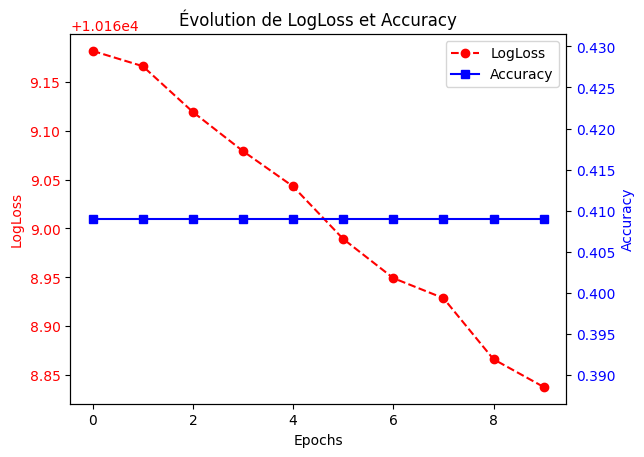

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('log.txt', sep=',', header=None)
fig, ax1 = plt.subplots()
# Tracer LogLoss sur le premier axe (gauche)
ax1.plot(data[0], label="LogLoss", color='red', linestyle="--", marker="o")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("LogLoss", color='red')
ax1.tick_params(axis='y', labelcolor='red')
# Créer un deuxième axe pour Accuracy (droite)
ax2 = ax1.twinx()
ax2.plot(data[1], label="Accuracy", color='blue', linestyle="-", marker="s")
ax2.set_ylabel("Accuracy", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Évolution de LogLoss et Accuracy")
plt.show()


## Step 2 : Mini Batch Gradient Descent

In [ ]:
%%writefile mini_linear_classification.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <time.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "fmatrix.cuh"
#include "read_csv.cuh"
#include "preprocess_data.cuh"
#include "classifier_math.cuh"
#include "evaluate_accuracy.cuh"
/* Includes, cuda */
#include <cuda_runtime.h>
#include <helper_cuda.h>

#include <unistd.h>

using namespace std;

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)


/////////////////////////////////////////////////////////
// Main program
/////////////////////////////////////////////////////////
int main(int argc, char **argv)
{

    /////////////////////////////////////////////////////////
    // Parameters for the data set
    /////////////////////////////////////////////////////////
    size_t N_train = 12000; // points for training (Google: 12000) // default 4
    size_t N_test = 5000; // points for validation (Google: 5000) // default 2
    size_t N = N_train;
    size_t Nall = N_train+N_test;
    /////////////////////////////////////////////////////////
    // Reading the data set
    /////////////////////////////////////////////////////////
    fmatrix alldata = fmatrix_create_on_host(Nall,data_columns);
    read_csv("sample_data/california_housing_train.csv",alldata.data,Nall,data_columns);
    //fmatrix_print(alldata);

    size_t D = data_columns-1+1; // remove output column, add column with const. 1.0
    size_t M = 2; // number of labels (one-hot encoding)
    fmatrix Xall = fmatrix_create_on_host(D,Nall);
    fmatrix Yall = fmatrix_create_on_host(M,Nall);
    get_inputs_and_labels(alldata.data,&Xall.data,&Yall.data,Nall,data_columns,D,M);
    /////////////////////////////////////////////////////////
    // Inputs and labels are now available in X and Y.
    // Each input is a column in X; X is of dimension D x N
    // each label is a column in Y; Y is of dimension M x N
    /////////////////////////////////////////////////////////

    // Logfile
    FILE* fp = fopen("log.txt", "w");

    /////////////////////////////////////////////////////////
    // Parameters for Stochastic Gradient Descent
    /////////////////////////////////////////////////////////
    // Default values
    int nb_iter = 200;           // default: 10;
    int periods = 200;      // reporting period
    int batch_size = 500;         // default: N, batche sizes are divisors of N ;
    float learning_rate = 1e-3; // default: 1e-7
    int seed = 42;              // default: 42 - Seed for the random shuffle of mini batch

    // Overwrites parameters with values from csv
    if (access("params.csv", F_OK) == 0) {
      fmatrix params = fmatrix_create_on_host(1, 3);
      read_csv("params.csv", params.data, 1, 3);
      nb_iter = getfm(params, 0, 1);
      periods = nb_iter;
      batch_size = getfm(params, 0, 2);
      learning_rate = getfm(params, 0, 0);
      fmatrix_free_on_host(&params);
    }


    /////////////////////////////////////////////////////////
    // Memory Allocation and Initialization
    /////////////////////////////////////////////////////////
    // take X,Y to be the first N columns of all data
    fmatrix h_X = fmatrix_subcolumns(Xall,0,N);
    fmatrix h_Y = fmatrix_subcolumns(Yall,0,N);
    fmatrix h_Xtest = fmatrix_subcolumns(Xall,N,Nall);
    fmatrix h_Ytest = fmatrix_subcolumns(Yall,N,Nall);
    fmatrix h_W = fmatrix_create_on_host(D,M);
    fmatrix h_J = fmatrix_create_on_host(1,1);

    /////////////////////////////////////////////////////////
    // Initializing Weight Matrix
    // its dimension is D x M
    /////////////////////////////////////////////////////////
    xavier_weight_init(1.0,h_W);

    //////////////////////////////
    // Copy data to device      //
    //////////////////////////////
    fmatrix d_X = fmatrix_copy_to_device(h_X);
    fmatrix d_Y = fmatrix_copy_to_device(h_Y);
    fmatrix d_Xtest = fmatrix_copy_to_device(h_Xtest);
    fmatrix d_Ytest = fmatrix_copy_to_device(h_Ytest);
    fmatrix d_W = fmatrix_copy_to_device(h_W);
    fmatrix d_J = fmatrix_copy_to_device(h_J);


    ////////////////////////////////////////////////////////////////
    // Normalize matrices X and X_test with mean and std of X     //
    ////////////////////////////////////////////////////////////////
    fmatrix *moments = compute_moments(d_X);
    normalize(d_X, moments[0], moments[1], 1);
    normalize(d_Xtest, moments[0], moments[1], 1);


    /////////////////////////////////////////
    // Create auxiliary matrices on device //
    /////////////////////////////////////////
    fmatrix d_Z = fmatrix_create_on_device(M,batch_size);
    fmatrix d_P = fmatrix_create_on_device(M,batch_size);
    //fmatrix d_G = fmatrix_create_on_device(D,M);
    // auxiliary matrix for computing Z=W^T X on test data
    fmatrix d_Ztest = fmatrix_create_on_device(M,d_Xtest.cols);

    /////////////////////////////////////////////////////////
    // Mini Batch Gradient Descent
    /////////////////////////////////////////////////////////
    //printf("Initial W after Xavier init:\n");
    //fmatrix_device_print(d_W);

     /* Evaluate the accuracy */
    float accuracy = 0;
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("initial accuracy: %f\n",accuracy);

    float J = 0;

    clock_t tstart_total, tend;
    tstart_total = clock();

    for (int i = 0; i < nb_iter; ++i ) {
      int batch_pointer = 0;
      // Shuffles matrices d_X and d_Y at each new epoch
      fmatrix_shuffle_col(d_X, d_Y, seed);

      fmatrix d_X_batch = fmatrix_create_on_device(d_X.rows, batch_size);
      fmatrix d_Y_batch = fmatrix_create_on_device(d_Y.rows, batch_size);

      while(batch_pointer < d_X.cols) {
        if (batch_pointer + batch_size <= d_X.cols) {
          // Update gradient for batch_size observations
          d_X_batch = fmatrix_subcolumns(d_X, batch_pointer, batch_pointer + batch_size);
          d_Y_batch = fmatrix_subcolumns(d_Y, batch_pointer, batch_pointer + batch_size);

          ////////////////////////////////
          // compute Z = W^T X
          // --> each column z of Z corresponds to one column x of X
          ////////////////////////////////
          fmatrix_tmult(d_Z,1.0,d_W,d_X_batch);

          ////////////////////////////////
          // For each column z of Z, compute activation p(z);
          // then update W
          ////////////////////////////////

          // compute softmax per column of Z and store in Z
          softmax_col(d_P, d_Z);

          // evaluate logloss (for reporting only)
          J = evaluate_logloss(d_P, d_Y_batch);

          ////////////////////////////////
          // Q:=P-Y
          // compute gradient G = XQ^T
          // ... possibly work with G here ...
          // update weights W = W - learning_rate*G
          ////////////////////////////////


          fmatrix_add(d_P, -1.0, d_Y_batch);
          fmatrix d_QT = fmatrix_create_on_device(d_P.cols, d_P.rows);
          fmatrix_transpose(d_QT, d_P);


          fmatrix d_G = fmatrix_create_on_device(d_X_batch.rows, d_QT.cols);

          fmatrix_mult(d_G, 1.0, d_X_batch, d_QT);
          fmatrix_free_on_device(&d_QT);
          fmatrix_add(d_W, -learning_rate, d_G);
          fmatrix_free_on_device(&d_G);


        } else {
          // Compute gradient for ultimate batch if N is not a multiple of batch_size
          // N % batch_size : remainder of euclidean div of N by batch size = size of last batch
          fmatrix d_X_end = fmatrix_create_on_device(d_X.rows, N%batch_size);
          d_X_end = fmatrix_subcolumns(d_X, batch_pointer, d_X.cols);
          fmatrix d_Y_end = fmatrix_create_on_device(d_Y.rows, N%batch_size);
          d_Y_end = fmatrix_subcolumns(d_Y, batch_pointer, d_Y.cols);
          fmatrix d_Z_end = fmatrix_create_on_device(M, N%batch_size);
          fmatrix d_P_end = fmatrix_create_on_device(M, N%batch_size);

          ////////////////////////////////
          // compute Z = W^T X
          // --> each column z of Z corresponds to one column x of X
          ////////////////////////////////
          fmatrix_tmult(d_Z_end,1.0,d_W,d_X_end);

          ////////////////////////////////
          // For each column z of Z, compute activation p(z);
          // then update W
          ////////////////////////////////

          // compute softmax per column of Z and store in Z
          softmax_col(d_P_end, d_Z_end);

          // evaluate logloss (for reporting only)
          J = evaluate_logloss(d_P_end, d_Y_end);

          ////////////////////////////////
          // Q:=P-Y
          // compute gradient G = XQ^T
          // ... possibly work with G here ...
          // update weights W = W - learning_rate*G
          ////////////////////////////////

          fmatrix_add(d_P_end, -1.0, d_Y_end);
          fmatrix d_QT_end = fmatrix_create_on_device(d_P_end.cols, d_P_end.rows);
          fmatrix_transpose(d_QT_end, d_P_end);

          fmatrix d_G_end = fmatrix_create_on_device(d_X_end.rows, d_QT_end.cols);

          fmatrix_mult(d_G_end, 1.0, d_X_end, d_QT_end);
          fmatrix_free_on_device(&d_QT_end);
          fmatrix_add(d_W, -learning_rate, d_G_end);
          fmatrix_free_on_device(&d_G_end);
        }

        batch_pointer += batch_size;

      }

      ////////////////////////////////
      // For reporting, compute logloss and accuracy at each epoch
      ////////////////////////////////
      if (i%(nb_iter/periods)==0) {
        float accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
        printf("iter: %d, logloss: %f, accuracy: %f\n", i, J, accuracy);
        fprintf(fp, "%f,%f\n", J, accuracy);
      }

    }
    tend = clock();
    float duration = ((float)(tend-tstart_total))/CLOCKS_PER_SEC;

    printf("final weights: \n");
    fmatrix_device_print(d_W);

    printf("Duration (s): %f\n",duration);

    /* Evaluate the accuracy */
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("final accuracy: %f\n",accuracy);

    /* Memory clean up */
    /** No need to free h_X, h_Y, h_Xtest, h_Ytest since
     *  they all point to Xall
     */
    fmatrix_free_on_host(&h_W);
    fmatrix_free_on_host(&Xall);
    fmatrix_free_on_host(&Yall);

    fmatrix_free_on_device(&d_X);
    fmatrix_free_on_device(&d_Y);
    fmatrix_free_on_device(&d_Xtest);
    fmatrix_free_on_device(&d_Ytest);
    fmatrix_free_on_device(&d_W);
    fmatrix_free_on_device(&d_Z);
    fmatrix_free_on_device(&d_J);

    // Close log file
    fclose(fp);
}

Overwriting mini_linear_classification.cu


### Compiling

In [ ]:
!nvcc -arch=sm_75 -Wno-deprecated-gpu-targets -I cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver mini_linear_classification.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu -o mini_batch.out

To obtain the result

In [ ]:
!./mini_batch.out

headers: "longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"!
Read 17000 rows.
Allocated memory for inputs: 17000 rows, 9 columns.
Allocated memory for labels: 17000 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	1	1	1	1	
-114.31	-114.47	-114.56	-114.57	-114.57	-114.58	-114.58	-114.59	-114.59	-114.6	
34.19	34.4	33.69	33.64	33.57	33.63	33.61	34.83	33.61	34.83	
15	19	17	14	20	29	25	41	34	46	
5612	7650	720	1501	1454	1387	2907	812	4789	1497	
1283	1901	174	337	326	236	680	168	1175	309	
1015	1129	333	515	624	671	1841	375	3134	787	
472	463	117	226	262	239	633	158	1056	271	
1.4936	1.82	1.6509	3.1917	1.925	3.3438	2.6768	1.7083	2.1782	2.1908	
Labels (first 10):
0	0	0	0	0	0	0	0	0	0	
1	1	1	1	1	1	1	1	1	1	
initial accuracy: 0.340200
iter: 0, logloss: 212.848816, accuracy: 0.341800
iter: 1, logloss: 207.535187, accuracy: 0.340200
iter: 2, logloss: 194.021057, accuracy: 0.309800
iter: 3, logloss: 196.418457, accurac

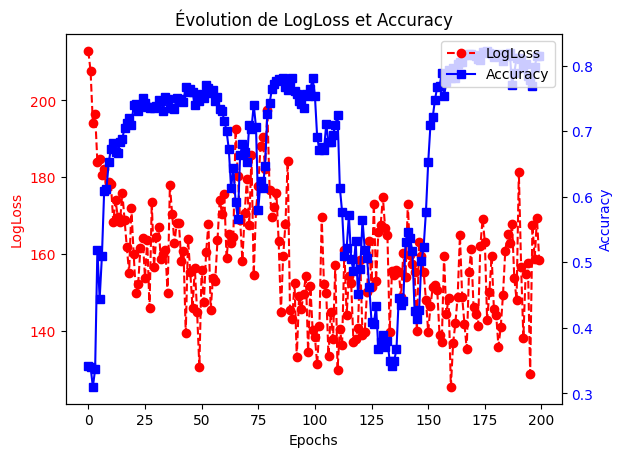

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('log.txt', sep=',', header=None)
fig, ax1 = plt.subplots()
# Tracer LogLoss sur le premier axe (gauche)
ax1.plot(data[0], label="LogLoss", color='red', linestyle="--", marker="o")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("LogLoss", color='red')
ax1.tick_params(axis='y', labelcolor='red')
# Créer un deuxième axe pour Accuracy (droite)
ax2 = ax1.twinx()
ax2.plot(data[1], label="Accuracy", color='blue', linestyle="-", marker="s")
ax2.set_ylabel("Accuracy", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Évolution de LogLoss et Accuracy")
plt.show()

## Step 3 : Hyper-parameters

We tested the code with different hyperparameters: learning rate, epochs, and batch size. Results are written in the file params.cvs and the **best one appears to be the one with learning rate 0.001, epochs 200 and batch-size 500**

In [ ]:
from google.colab import data_table
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
from tqdm.notebook import tqdm

rates = [1e-7, 1e-5, 1e-3, 1e-1, 1]
iterations = [10, 100, 200, 500]
batches = [32, 64, 128, 256, 512, 1024]


df = []
best_accuracy, best_lr, best_iter, best_bs = 0, 0, 0, 0
for lr in tqdm(rates):
  for iter in tqdm(iterations, leave=False):
    for bs in tqdm(batches, leave=False):
      # Write hyperparameters to csv file
      parameters = f"{lr},{iter},{bs}\n"
      with open("params.csv", 'w') as f:
        lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
        f.writelines(lines)

      # Run program, accessing the hyperparameters from the csv file
      cmd_run = "./mini_batch.out"
      run = subprocess.run(cmd_run, shell=True, capture_output=True)

      # Parse final accuracy for comparison
      final_accuracy = float(run.stdout.decode("utf-8").split("\n")[-2].split(": ")[-1])
      duration = float(run.stdout.decode("utf-8").split("\n")[-3].split(": ")[-1])

      # Save values into list
      df.append([lr, iter, bs, final_accuracy, duration])
      if final_accuracy > best_accuracy:
        best_accuracy, best_lr, best_iter, best_bs = final_accuracy, lr, iter, bs
print(f"Best accuracy {best_accuracy} obtained for learning_rate {best_lr}, {best_iter} iterations and batch size of {best_bs}.")
df = pd.DataFrame(df, columns=["Learning rate", "Number of iterations", "Batch Size", "Final accuracy", "Duration"])
data_table.DataTable(df, include_index=False, num_rows_per_page=50, min_width="30")

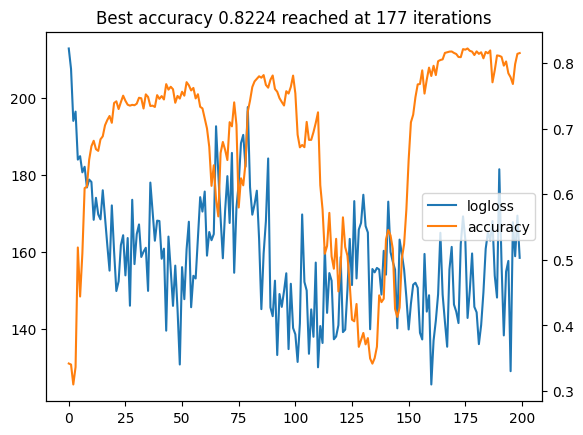

In [ ]:
parameters = f"0.001,200,512\n"
with open("params.csv", 'w') as f:
  lines = ['"Learning_rate","Number_iteration","Batch_size"\n', parameters]
  f.writelines(lines)
cmd_run = "./mini_batch_noshuffle.out"
run = subprocess.run(cmd_run, shell=True, capture_output=True)

data = pd.read_csv('log.txt',sep=',',header=None)
best_accuracy = np.max(data[1])
iteration = np.argmax(data[1]) + 1
fig,ax = plt.subplots()
l1 = ax.plot(data[0],label="logloss")
ax2=ax.twinx()
ax2.plot([], [])
l2 = ax2.plot(data[1],label="accuracy")

lines = l1 + l2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=7)
ax.set_title(f"Best accuracy {best_accuracy} reached at {iteration} iterations")
plt.show()

# Debugging
Compile with debugging info on the host (`-g`) and device (`-G`).


In [ ]:
!nvcc -g -G -I cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver linear_classification.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

Run the debugger cuda-gdb, stopping at the first error that is detected. Shows first the call stack on the GPU, the values of local variables, then the call stack on the host (thread 1).

In [ ]:
! printf "set cuda memcheck on\nset cuda api_failures stop\ncatch throw\nr\nbt\ninfo locals\nthread 1\nbt\n" > tmp.txt
! cat tmp.txt
! cuda-gdb -batch -x tmp.txt ./a.out

In [ ]:
!cuda-memcheck ./a.out

# Test


In [ ]:
%%writefile test.cu
#include "fmatrix.cuh"
#include "classifier_math.cu"

int main() {
    // create a random matrix
    fmatrix A = fmatrix_create_random_on_device(2,1);
    fmatrix B = fmatrix_create_random_on_device(1,2);
    fmatrix C = fmatrix_create_random_on_device(1,1);
    printf("original matrix:\n");
    fmatrix_device_print(B);
    fmatrix_device_print(C);
    // add the matrix to itself
    fmatrix_tmult(A,1.0,B,C);
    // print
    printf("matrix result:\n");
    fmatrix_device_print(A);
    // free the memory
    fmatrix_free_on_device(&A);
    fmatrix_free_on_device(&B);
    fmatrix_free_on_device(&C);
}